In [1]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE

In [2]:
best_comb_filename = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/output/best_comb_cup.pkl'
param_grid_filename = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/output/param_grid_cup.pkl'

In [3]:
df = get_data('/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/MONK/monks-1.train')
df_test = get_data('/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/MONK/monks-1.test')

In [4]:
X_train, y_train = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test, y_test = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

# DATA PREPARATION

X_train = onehot_encoding(X_train)
X_test = onehot_encoding(X_test)

In [3]:
best_comb = load_dict_from_file(best_comb_filename)
param_grid = load_dict_from_file(param_grid_filename)

In [6]:
print(param_grid)

[{'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 10, 'hidden_act_func1': 'sigm', 'dim_hidden2': 10, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'results': {'train_loss_mean': 1.3420407399655638, 'train_loss_std': 0.2852433895780706, 'val_loss_mean': 2.109295985587662, 'val_loss_std': 0.601367532567357, 'train_MEE_mean': 1.7878395707692358, 'train_MEE_std': 0.1724793682551471, 'val_MEE_mean': 2.091949818656352, 'val_MEE_std': 0.23218154973112295}, 'elapsed_time': 342.32443404197693}, {'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 10, 'hidden_act_func1': 'sigm', 'dim_hidden2': 15, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'results': {'train_loss_mean': 0.8835250871460723, 'train_loss_std': 0.08650914713704852, 'val_loss_mean': 1.6367433732425583, 'val_loss_std': 0.3773294424421882, 'train_MEE_mean': 1.4478270011556822, 'train_MEE_std': 0.07261435965247337, 'v

In [8]:
p_best = []
for p_comb in param_grid:
    if p_comb['results']['val_loss_mean'] < 2:
        print(p_comb)
        p_best.append(p_comb)

{'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 10, 'hidden_act_func1': 'sigm', 'dim_hidden2': 15, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'results': {'train_loss_mean': 0.8835250871460723, 'train_loss_std': 0.08650914713704852, 'val_loss_mean': 1.6367433732425583, 'val_loss_std': 0.3773294424421882, 'train_MEE_mean': 1.4478270011556822, 'train_MEE_std': 0.07261435965247337, 'val_MEE_mean': 1.8412971878874387, 'val_MEE_std': 0.1375264990119138}, 'elapsed_time': 435.3162362575531}
{'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 10, 'hidden_act_func1': 'sigm', 'dim_hidden2': 20, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'results': {'train_loss_mean': 0.7264994969029335, 'train_loss_std': 0.09858050809577074, 'val_loss_mean': 1.4580250482500114, 'val_loss_std': 0.38299688104796314, 'train_MEE_mean': 1.3023899187163148, 'train_MEE_std': 0.08818459442024644, 

Epoch 0: train_loss: 7.335e-01, test_loss: 7.411e-01; train_accuracy: 5.000e+01, test_accuracy: 5.000e+01  train_MSE: 2.692e-01, test_MSE: 2.727e-01  lr : 0.027838821814150108
Epoch 1: train_loss: 6.902e-01, test_loss: 7.012e-01; train_accuracy: 5.323e+01, test_accuracy: 5.069e+01  train_MSE: 2.485e-01, test_MSE: 2.540e-01  lr : 0.027838821814150108
Epoch 2: train_loss: 6.772e-01, test_loss: 6.924e-01; train_accuracy: 6.129e+01, test_accuracy: 5.301e+01  train_MSE: 2.420e-01, test_MSE: 2.496e-01  lr : 0.027838821814150108
Epoch 3: train_loss: 6.696e-01, test_loss: 6.908e-01; train_accuracy: 5.806e+01, test_accuracy: 4.774e+01  train_MSE: 2.383e-01, test_MSE: 2.488e-01  lr : 0.027838821814150108
Epoch 4: train_loss: 6.590e-01, test_loss: 6.859e-01; train_accuracy: 6.210e+01, test_accuracy: 5.162e+01  train_MSE: 2.331e-01, test_MSE: 2.464e-01  lr : 0.027838821814150108
Epoch 5: train_loss: 6.441e-01, test_loss: 6.770e-01; train_accuracy: 7.097e+01, test_accuracy: 5.845e+01  train_MSE: 2.

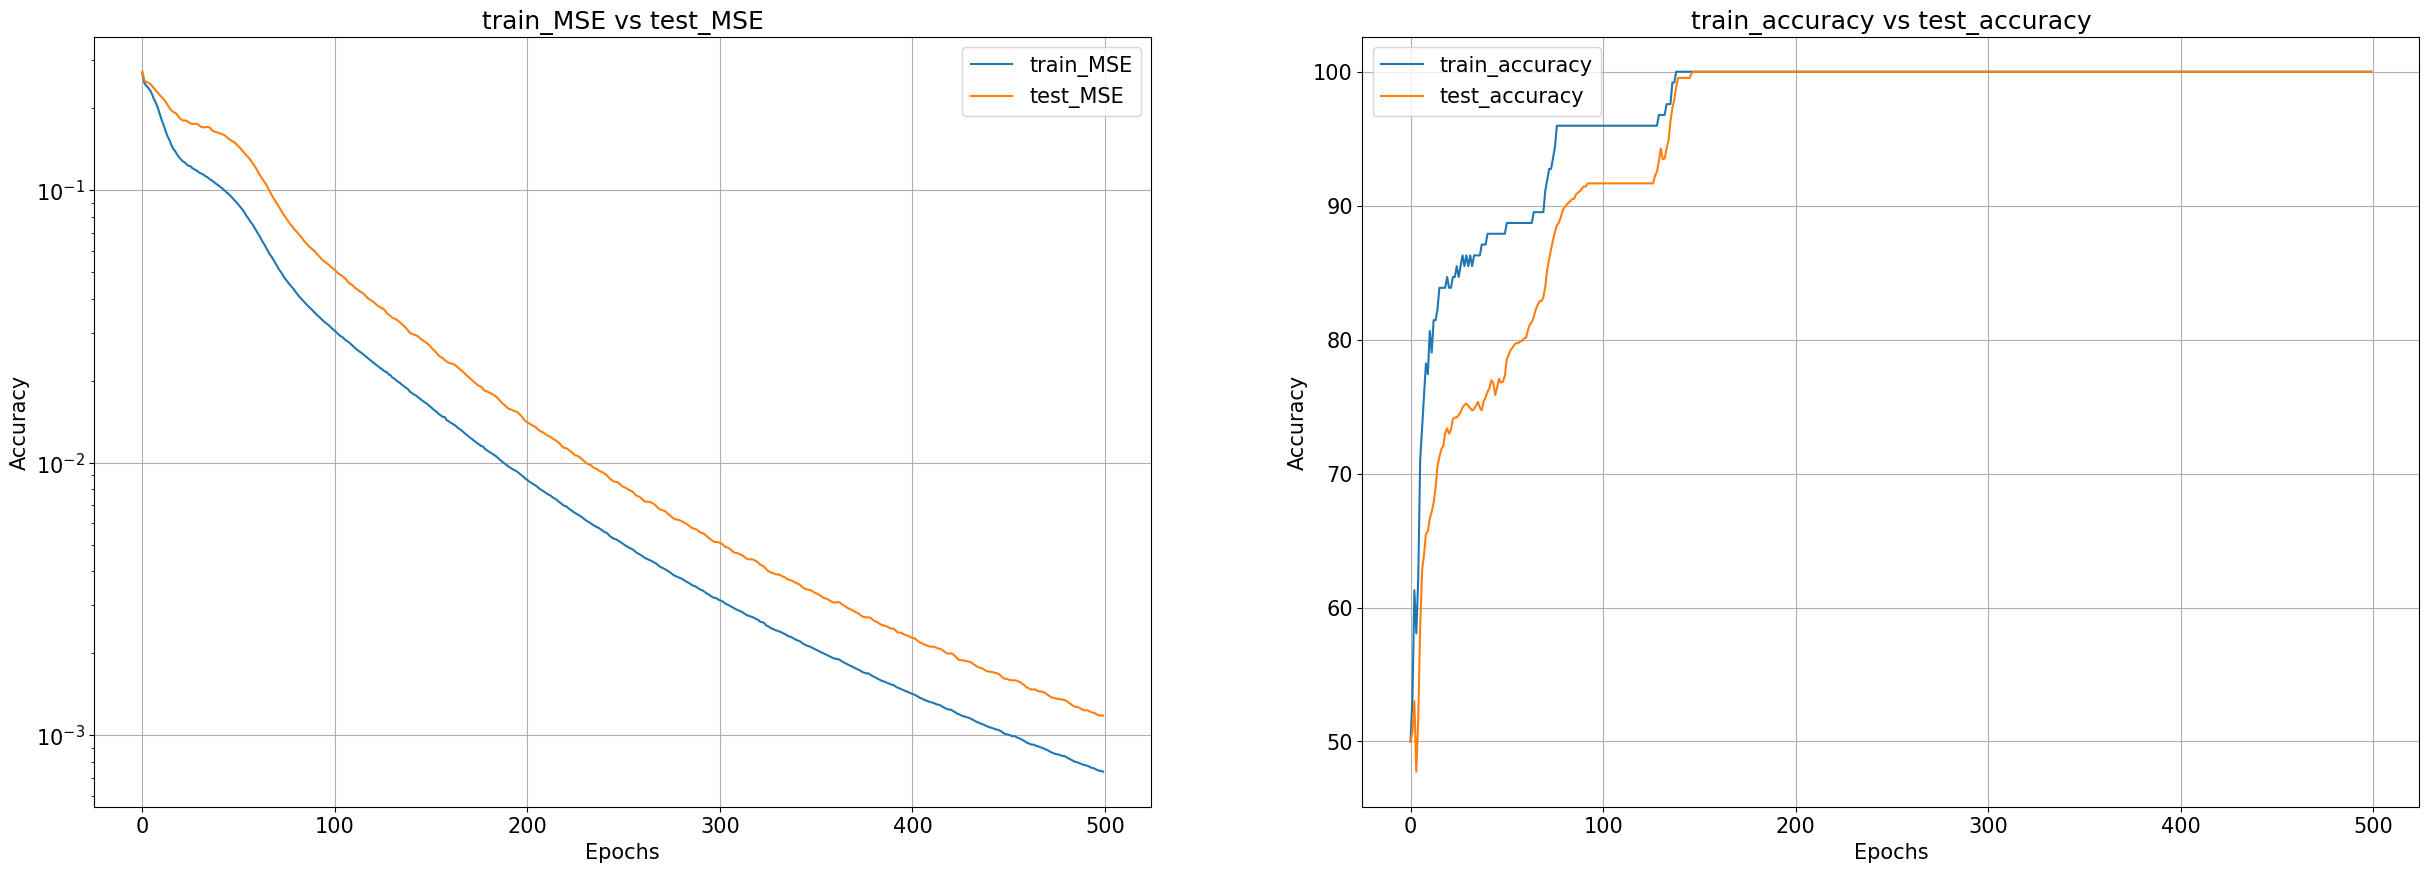

Epoch 0: train_loss: 7.050e-01, test_loss: 7.087e-01; train_accuracy: 5.000e+01, test_accuracy: 5.000e+01  train_MSE: 2.558e-01, test_MSE: 2.576e-01  lr : 0.11135528725660043
Epoch 1: train_loss: 6.812e-01, test_loss: 6.935e-01; train_accuracy: 4.839e+01, test_accuracy: 4.769e+01  train_MSE: 2.441e-01, test_MSE: 2.502e-01  lr : 0.11135528725660043
Epoch 2: train_loss: 6.719e-01, test_loss: 6.935e-01; train_accuracy: 4.919e+01, test_accuracy: 4.884e+01  train_MSE: 2.397e-01, test_MSE: 2.502e-01  lr : 0.11135528725660043
Epoch 3: train_loss: 6.512e-01, test_loss: 6.797e-01; train_accuracy: 6.048e+01, test_accuracy: 5.093e+01  train_MSE: 2.294e-01, test_MSE: 2.435e-01  lr : 0.11135528725660043
Epoch 4: train_loss: 6.309e-01, test_loss: 6.660e-01; train_accuracy: 7.500e+01, test_accuracy: 6.227e+01  train_MSE: 2.193e-01, test_MSE: 2.366e-01  lr : 0.11135528725660043
Epoch 5: train_loss: 6.118e-01, test_loss: 6.552e-01; train_accuracy: 7.742e+01, test_accuracy: 6.551e+01  train_MSE: 2.099e-

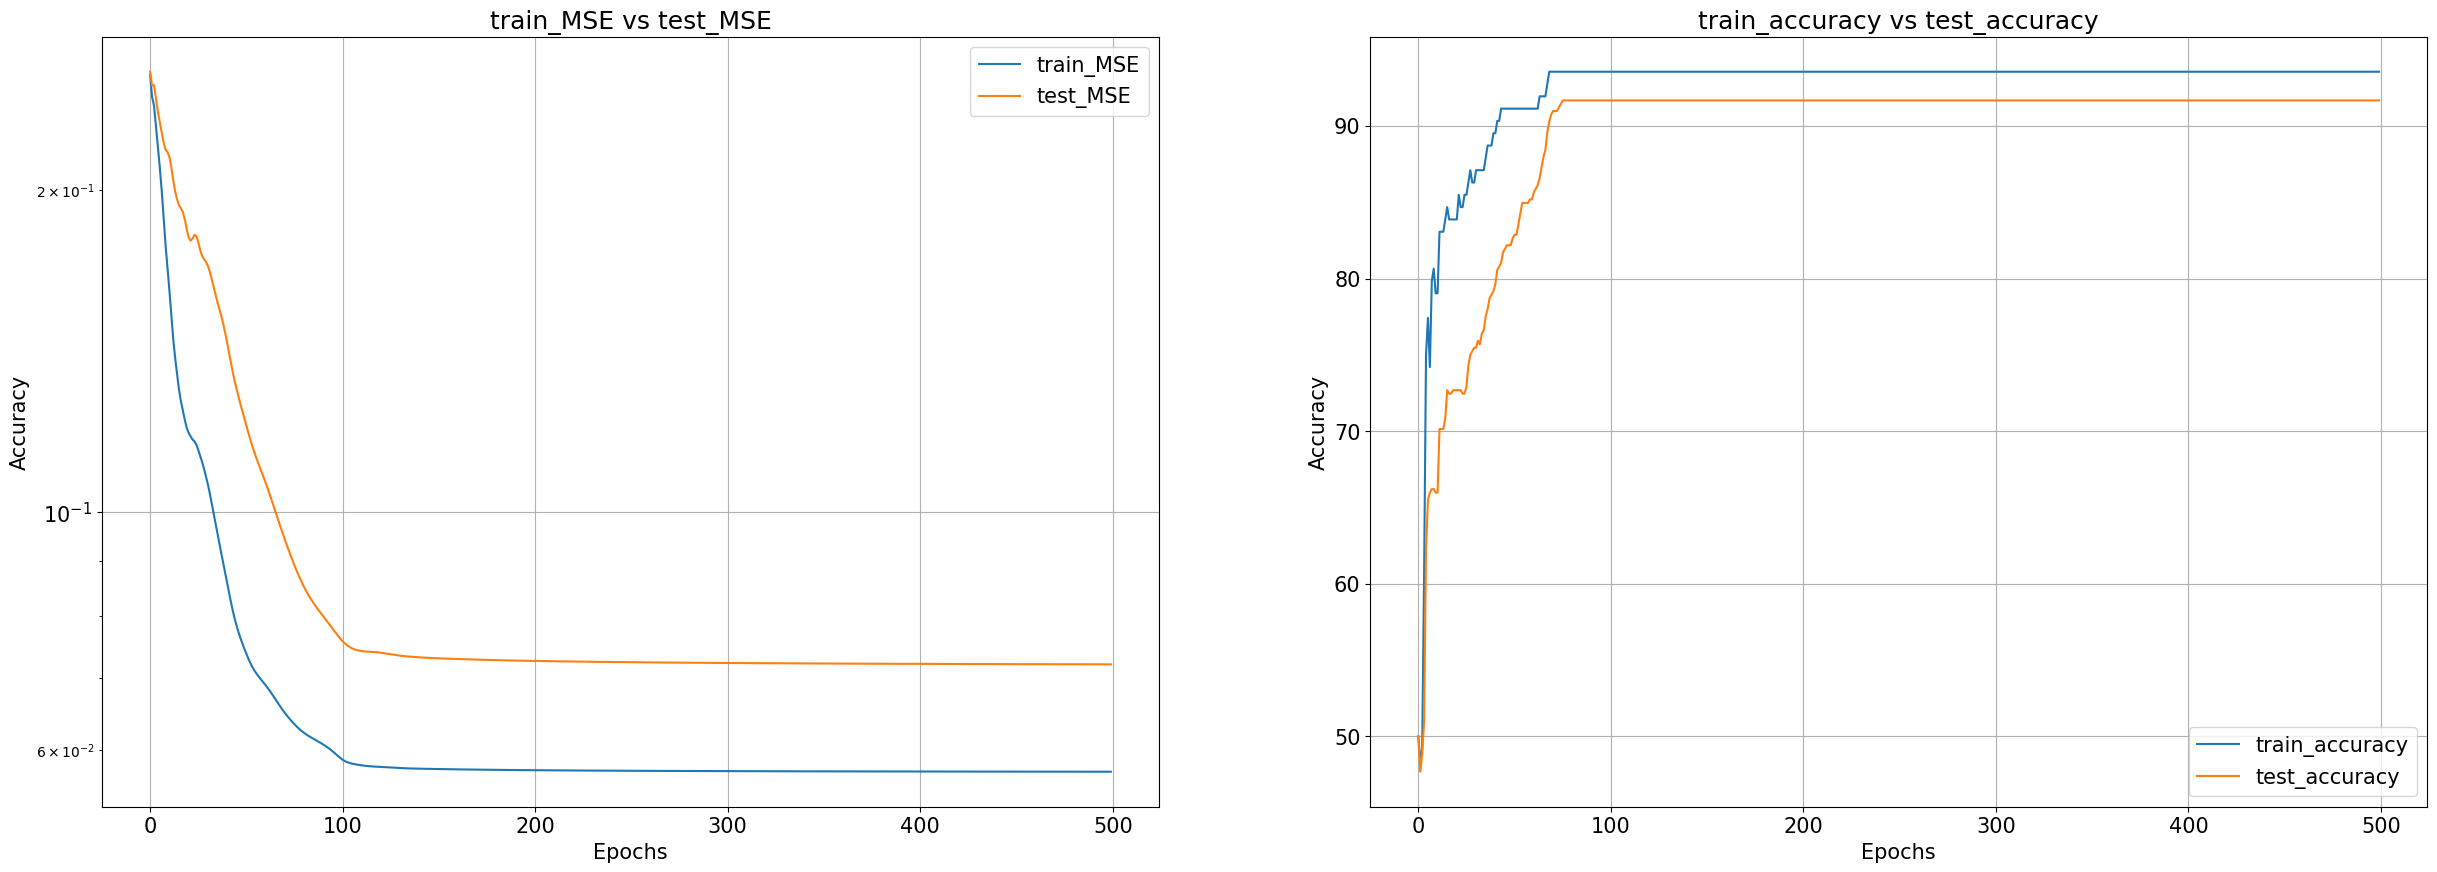

Epoch 0: train_loss: 7.001e-01, test_loss: 7.037e-01; train_accuracy: 5.000e+01, test_accuracy: 5.000e+01  train_MSE: 2.535e-01, test_MSE: 2.552e-01  lr : 0.11135528725660043
Epoch 1: train_loss: 6.941e-01, test_loss: 6.980e-01; train_accuracy: 5.000e+01, test_accuracy: 5.000e+01  train_MSE: 2.505e-01, test_MSE: 2.524e-01  lr : 0.11135528725660043
Epoch 2: train_loss: 6.871e-01, test_loss: 6.939e-01; train_accuracy: 5.000e+01, test_accuracy: 5.000e+01  train_MSE: 2.470e-01, test_MSE: 2.504e-01  lr : 0.11135528725660043
Epoch 3: train_loss: 6.746e-01, test_loss: 6.859e-01; train_accuracy: 6.855e+01, test_accuracy: 5.926e+01  train_MSE: 2.408e-01, test_MSE: 2.464e-01  lr : 0.11135528725660043
Epoch 4: train_loss: 6.625e-01, test_loss: 6.803e-01; train_accuracy: 6.774e+01, test_accuracy: 5.532e+01  train_MSE: 2.348e-01, test_MSE: 2.436e-01  lr : 0.11135528725660043
Epoch 5: train_loss: 6.472e-01, test_loss: 6.746e-01; train_accuracy: 6.613e+01, test_accuracy: 5.347e+01  train_MSE: 2.275e-

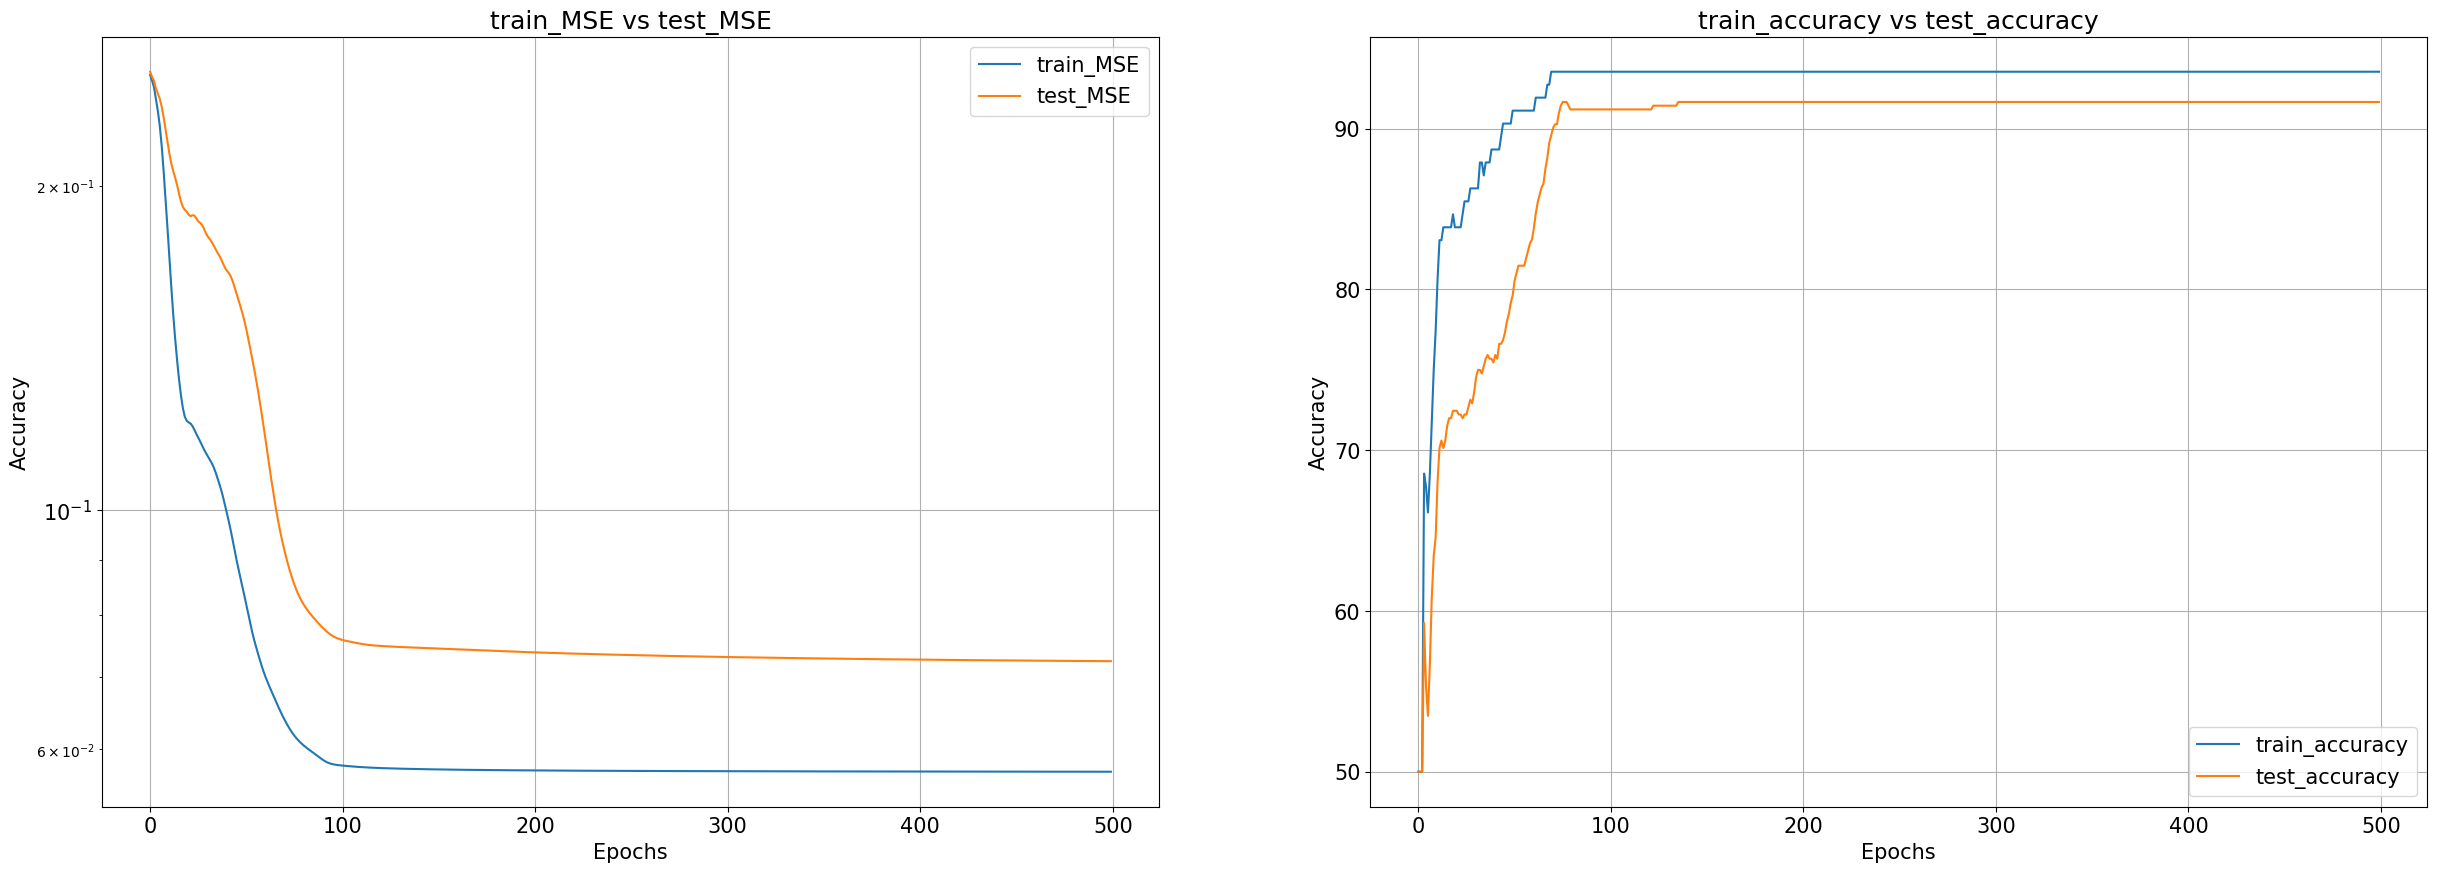

Epoch 0: train_loss: 7.224e-01, test_loss: 7.004e-01; train_accuracy: 4.435e+01, test_accuracy: 5.023e+01  train_MSE: 2.645e-01, test_MSE: 2.536e-01  lr : 0.1
Epoch 1: train_loss: 6.886e-01, test_loss: 6.802e-01; train_accuracy: 5.323e+01, test_accuracy: 5.793e+01  train_MSE: 2.478e-01, test_MSE: 2.435e-01  lr : 0.1
Epoch 2: train_loss: 6.466e-01, test_loss: 6.712e-01; train_accuracy: 6.129e+01, test_accuracy: 5.851e+01  train_MSE: 2.272e-01, test_MSE: 2.390e-01  lr : 0.1
Epoch 3: train_loss: 6.035e-01, test_loss: 6.453e-01; train_accuracy: 7.419e+01, test_accuracy: 6.991e+01  train_MSE: 2.059e-01, test_MSE: 2.261e-01  lr : 0.1
Epoch 4: train_loss: 5.574e-01, test_loss: 6.186e-01; train_accuracy: 7.742e+01, test_accuracy: 6.852e+01  train_MSE: 1.845e-01, test_MSE: 2.139e-01  lr : 0.1
Epoch 5: train_loss: 4.927e-01, test_loss: 5.882e-01; train_accuracy: 8.065e+01, test_accuracy: 7.031e+01  train_MSE: 1.574e-01, test_MSE: 2.013e-01  lr : 0.1
Epoch 6: train_loss: 4.527e-01, test_loss: 5.5

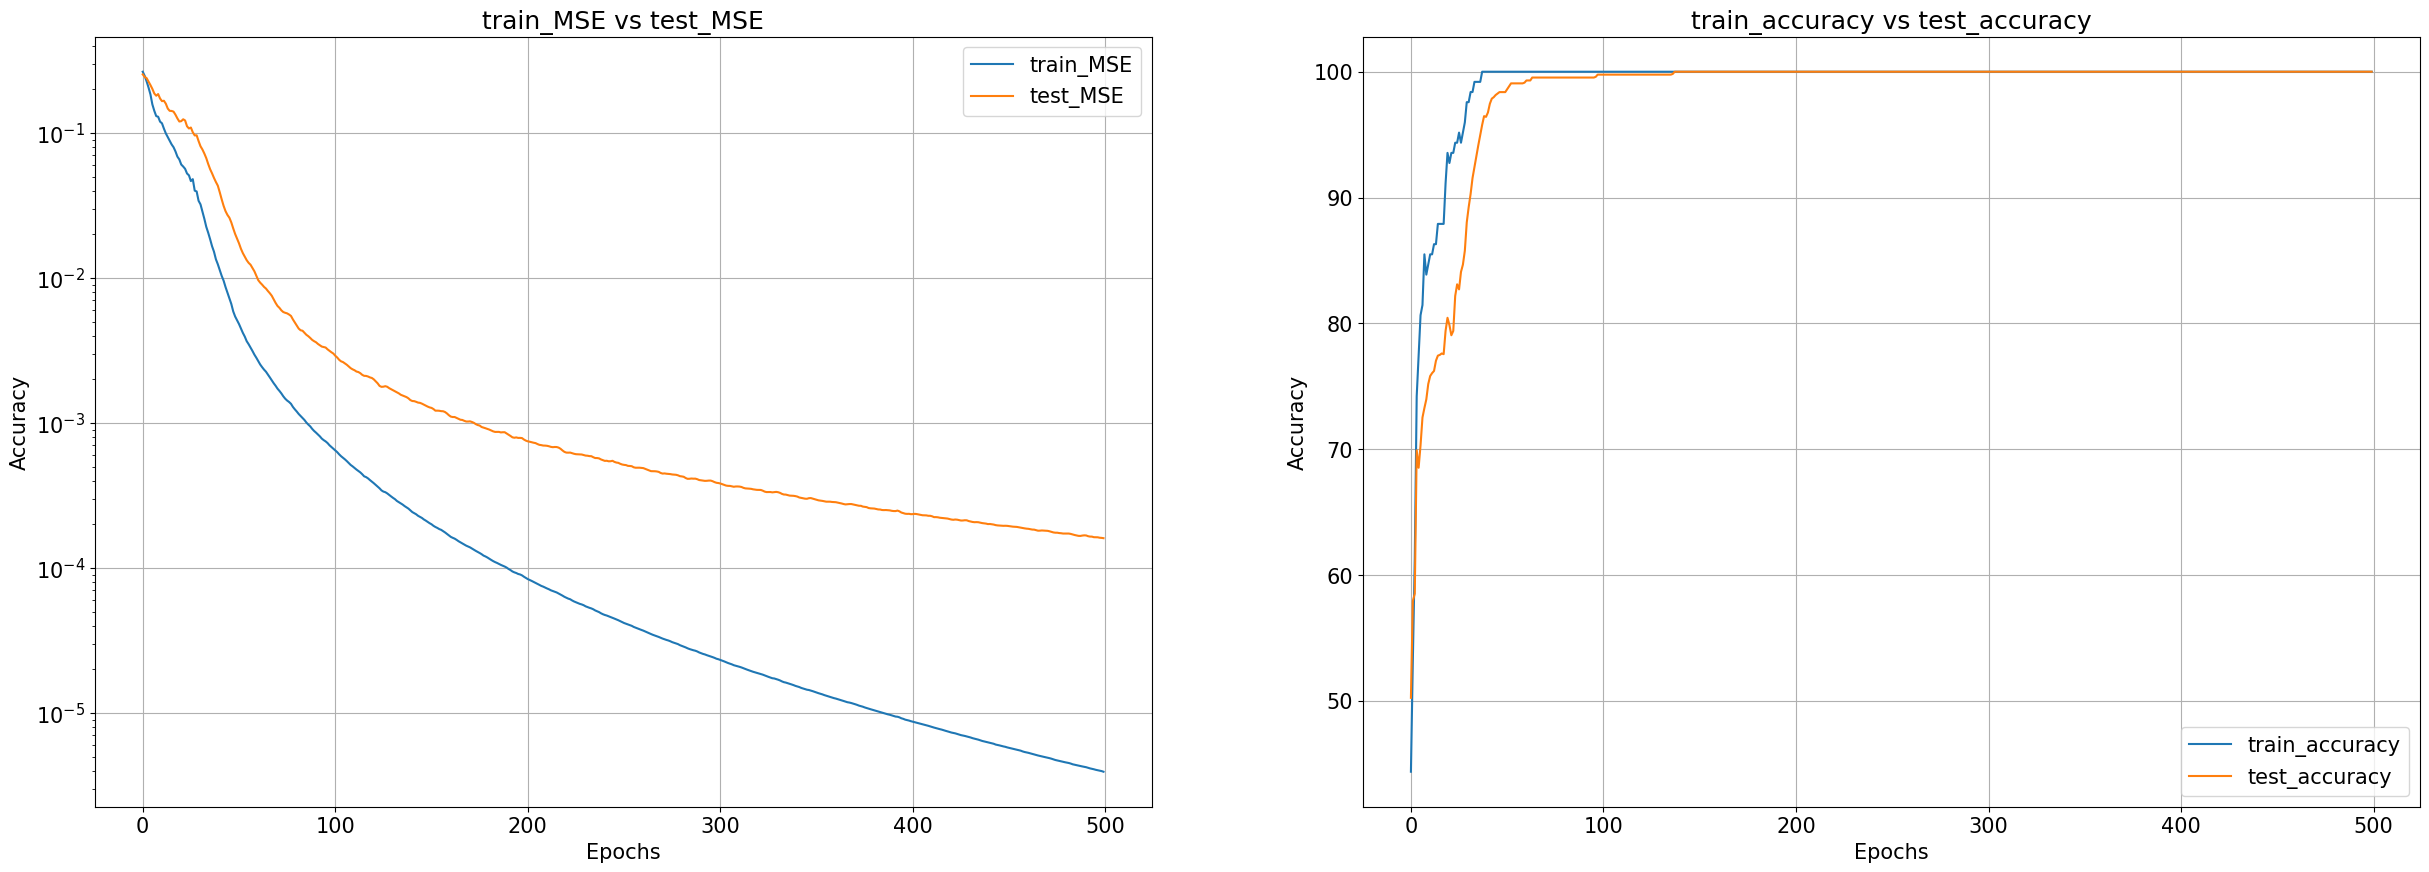

In [9]:
for i,p_comb in enumerate(p_best):

    best_comb = p_comb.copy()

    results = best_comb.pop('results')
    if best_comb['n_batch'] == 'batch':
        best_comb['n_batch'] = X_train.shape[1]
    elapsed_time = best_comb.pop('elapsed_time')
    if best_comb['scale_eta_batchsize'] == 'lin':
        best_comb['eta'] = best_comb['eta'] * best_comb['n_batch']
    if best_comb['scale_eta_batchsize'] == 'sqrt':
        best_comb['eta'] = best_comb['eta'] * np.sqrt(best_comb['n_batch'])
    best_comb.pop('scale_eta_batchsize')

    #print(best_comb)
    #print(results)
    
    input_layer = Input(X_train.shape[0])
    hidden_layer = Layer(input_layer, best_comb.pop('dim_hidden'), best_comb.pop('hidden_act_func'))
    output_layer = Layer(hidden_layer, 1, 'sigm')

    model = NeuralNetwork(input_layer, output_layer, 'binary_crossentropy', metrics=[accuracy, MSE])
    history = model.retrain(X_train, y_train.reshape((1,X_train.shape[1])), test_data = [X_test,y_test.reshape((1,X_test.shape[1]))], **best_comb)

    '''plt.figure(1)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['test_loss'], label='test_loss')
    plt.yscale('log')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Loss functions', size=15)
    plt.title('train_loss vs test_loss', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)

    plt.figure(2)
    plt.plot(history['train_accuracy'],label='train_accuracy')
    plt.plot(history['test_accuracy'], label='test_accuracy')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Accuracy', size=15)
    plt.title('train_accuracy vs test_accuracy', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)'''

    plt.figure(i, figsize=(30,10))
    plt.subplot(1,2,1)
    plt.plot(history['train_MSE'],label='train_MSE')
    plt.plot(history['test_MSE'], label='test_MSE')
    plt.yscale('log')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Accuracy', size=15)
    plt.title('train_MSE vs test_MSE', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history['train_accuracy'],label='train_accuracy')
    plt.plot(history['test_accuracy'], label='test_accuracy')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Accuracy', size=15)
    plt.title('train_accuracy vs test_accuracy', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)

    plt.show()